# Modeling FEMA Payouts

To recap where we are in the workflow, up to this point the team has:
 - Programmatically pulled down **Disaster Historicals** from FEMA's publically availably API. The data we have pulled dates back to 2009.
 - Overlaid **Disaster Details** to supplement the historical data on hand, which includes things like *Disaster Type.*
 - Integrated these two datasets together.
 
In this notebook, we will take time to engineer new features, conduct EDA, and build a model to help support FEMA in estimating payouts at the zipcode level. When a new disaster strikes, this model will help to identify zipcodes that are likely to need the most support. This notebook breaks down into the following sections:

 - [Cleaning](#Clean-our-Data)
 - [Feature Engineering](#Feature-Engineering)
 - [EDA](#EDA)
 - [Modeling](#Modeling)
 
As with all workflows, the first step is to read in our data...


In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [106]:
df = pd.read_csv('./data/disaster_income.csv')

***
## Clean our Data

There are a number of duplicative columns in our data set that we can drop from the outset. While approved fund features are interesting, this will not be the target we work against.

#### Dropping Irrelevant Features

In [107]:
df = df.drop(columns=['approve_1_10000', 'approve_10001_25000', 'approve_25001_max'])

In [108]:
df = df.drop(columns=['Unnamed: 0', 'disaster_type'])

Upon reading in our data, we notice that there are some special characters that will impede calculation/ application of aggregate functions. We'll take a moment to adjust these columns and dheck for *dtypes.*

In [109]:
df['Median'] = df['Median'].str.replace(",","")
df['Mean'] = df['Mean'].str.replace(",","")
df['Pop'] = df['Pop'].str.replace(",","")

In [110]:
df['Median'] = df['Median'].astype('int')
df['Mean'] = df['Mean'].astype('int')
df['Pop'] = df['Pop'].astype('int')

#### Adjusting Dtypes

In [111]:
#### Adjusting Dtypes
df['incident_begin'] = pd.to_datetime(df['incident_begin'])
df['incident_end'] = pd.to_datetime(df['incident_end'])

In [112]:
df = df[df['incident_type'] != 'Typhoon']

In [113]:
df = df[df.state != 'VI']
df = df[df.state != 'MP']
df = df[df.state != 'NV']

***
## Feature Engineering

There are a number of additional features we'd like to bring into our dataset. While *incident start* and *incident end* are interesting and useful features, **duration of disaster** is likely to be an important consideration when modeling out FEMA support. For that reason, we'll take a moment to build this into our model.

#### Duration

In [114]:
df['duration'] = df['incident_end'] - df['incident_begin']

In [115]:
df['duration'] = df['duration'] /  np.timedelta64(1, 'D')

#### Going Deeper with FEMA Registrations

Part of the FEMA data retrieved via API includes *valid_registration* at the zipcode level. As provided by FEMA, this feature is defined as:

  - "*Count of FEMA registration owners within the state, county, zip where the registration is valid. In order to be a valid registration, the applicant must be in an Individual Assistance declared state and county and have registered within the FEMA designated registration period.*"
  
This is an interesting pre-existing feature and can tell us a good deal about the level of support a zipcode may need. However, we are only provided total registrations with not purview into coverage for the zipcode. For this reason, we will build a **registrations per capita** feature.
 

In [116]:
df['registrations_per_capita'] = df['valid_registration'] / df['Pop'] * 100

In [117]:
df['registrations_per_capita']

0        0.036031
1        0.053476
2        0.035458
3        0.048333
4        0.011918
           ...   
68731    1.327434
68732    0.034188
68733    0.205761
68734    0.948509
68735    0.952381
Name: registrations_per_capita, Length: 68731, dtype: float64

In [118]:
df = df.drop(columns=['inspect_1_10000', 'inspect_10001_20000', 'inspect_20001_30000',
       'inspect_greater_30000','tot_inspected'])

In [119]:
df.columns

Index(['disaster_number', 'incident_type', 'incident_begin', 'incident_end',
       'state', 'county', 'city', 'zipCode', 'valid_registration',
       'avg_damage', 'tot_damage', 'no_damage', 'approve_assistance',
       'tot_approve_ihp_amt', 'repair_replace_amt', 'rental_amt',
       'other_needs_amt', 'tot_max_grants', 'Median', 'Mean', 'Pop',
       'duration', 'registrations_per_capita'],
      dtype='object')

In [122]:
df.dtypes

disaster_number               int64
incident_type                object
state                        object
county                       object
city                         object
zipCode                       int64
valid_registration            int64
avg_damage                    int64
tot_damage                    int64
no_damage                     int64
approve_assistance            int64
tot_approve_ihp_amt         float64
repair_replace_amt          float64
rental_amt                  float64
other_needs_amt             float64
tot_max_grants                int64
Median                        int32
Mean                          int32
Pop                           int32
duration                    float64
registrations_per_capita    float64
dtype: object

In [120]:
df = df.drop(columns=['incident_begin', 'incident_end'])

In [121]:
df.head()

,disaster_number,incident_type,state,county,city,zipCode,valid_registration,avg_damage,tot_damage,no_damage,...,tot_approve_ihp_amt,repair_replace_amt,rental_amt,other_needs_amt,tot_max_grants,Median,Mean,Pop,duration,registrations_per_capita
0,4195,Flood,MI,Macomb,CLINTON TWP,48036,8,3743,26202,1,...,21146.0,20899.0,0.0,247.0,0,49516,60922,22203,2.0,0.036031
1,4195,Flood,MI,Macomb,RAY,48096,2,1491,2984,0,...,5094.0,2972.0,1692.0,430.0,0,67344,96911,3740,2.0,0.053476
2,4195,Flood,MI,Macomb,CLINTON TWP,48038,14,3925,43178,3,...,3616.0,854.0,1692.0,1069.0,0,56119,67880,39483,2.0,0.035458
3,4195,Flood,MI,Macomb,RICHMOND,48062,4,1671,6686,1,...,2760.0,2627.0,0.0,132.0,0,58233,67564,8276,2.0,0.048333
4,4195,Flood,MI,Macomb,STERLING HTS,48310,5,1538,7691,1,...,0.0,0.0,0.0,0.0,0,56943,65435,41955,2.0,0.011918


In [ ]:
df_for_model = df.drop(columns=['zipCode', 'city', 'county', ])

In [89]:
# df[df = df.drop(columns=['zipCode', 'city', 'county', ])'zipCode'] = df['zipCode'].astype('object')

***
## EDA

Now that we have generated our new features and culled down the original feature set, let's take a moment to dig into the data. We'll start by looking at correlations across features, and our target *tot_approve_ihp_amt*.

#### Correlation

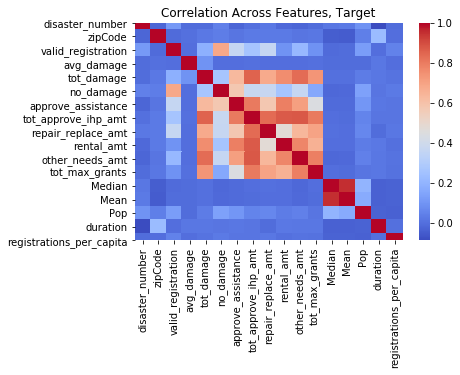

In [90]:
#Assess correlations of our prioritized feature set
sns.heatmap(df.corr(), cmap='coolwarm');
plt.title('Correlation Across Features, Target');

Our initial assessment of correlation of our target relative to our features reveals that there is actually minimal correlation between median/mean income and the support provided at the zipcode level. This is a positive finding and also negates our original hypothesis that there may be bias in terms of geo-prioritization post disaster. Let's dig a little bit deeper here to ensure that there aren't any outliers. We can also leverage our Tableau tool to confirm this.

#### Target Deep Dive

We'll now take a moment to look at the distribution of our target. Clearly, there are some disaster payouts skewing our distribution below...

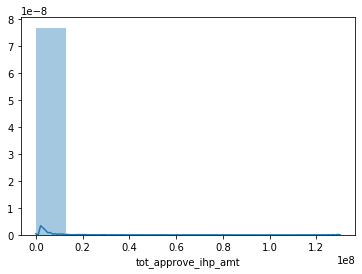

In [91]:
#Build histogram of our target
sns.distplot(df['tot_approve_ihp_amt'], bins=  10);

We'll now take a moment to look at the distribution of our target. Clearly, our distribution is being skewed in two ways:
 - There appear to be a significant amount of instances with **no payout**
 - There appears to be a small number of **significant payouts**
 
Let's take time to epxlore both of these...

#### NO PAYOUT: When and Where, and How Often

***How Often FEMA doesn't pay out***

In [92]:
#Find the percent of instances where there is no payout
df.loc[df['tot_approve_ihp_amt'] ==0].count()[0] / len(df['tot_approve_ihp_amt'])

0.29382665754899534

***When FEMA doesn't pay out:*** Percentage of the time that there is no payout by incident type

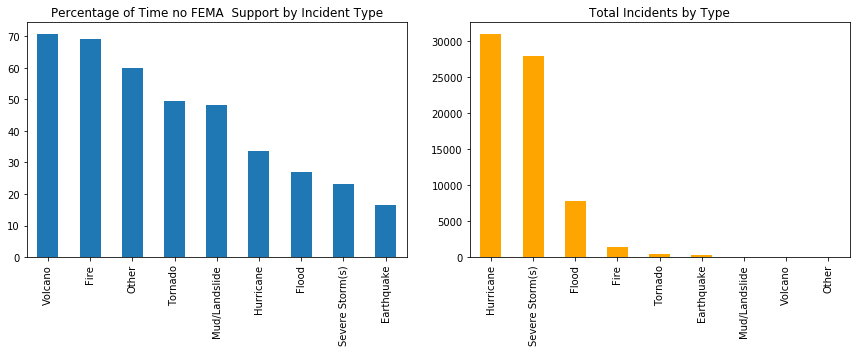

In [93]:
# Number of occurences with no payout, divided by total number of occurences.
# Arrange by percentage 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
((df.loc[df['tot_approve_ihp_amt'] ==0, 'incident_type'].value_counts() / df['incident_type'].value_counts()).sort_values(ascending=False) * 100).plot(kind='bar');
plt.title('Percentage of Time no FEMA  Support by Incident Type');

# Number of occurences by incident type
# Arrange by total
plt.subplot(1,2,2)
df['incident_type'].value_counts().sort_values(ascending=False).plot(kind='bar', color='orange');
plt.title('Total Incidents by Type');

plt.tight_layout()

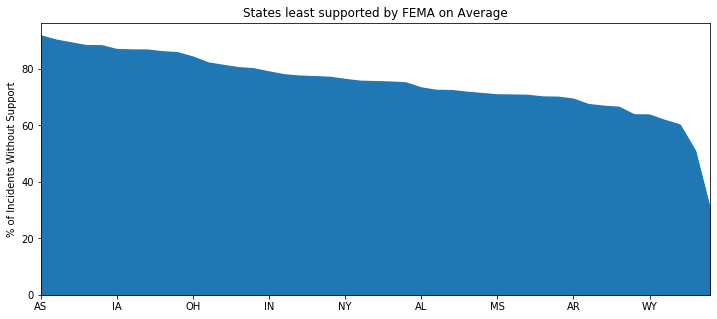

In [98]:
#Where does FEMA not payout? Check by State
plt.figure(figsize=(12,5))
((df.loc[df['tot_approve_ihp_amt'] > 0, 'state'].value_counts() / df['state'].value_counts()).sort_values(ascending=False) * 100).plot(kind='area');
plt.title('States least supported by FEMA on Average');
plt.ylabel('% of Incidents Without Support');


#### PAYOUT: When, Where, How Often

In [37]:
#Check average of payouts excluding zeros
support_avg = df.loc[df['tot_approve_ihp_amt'] > 0, 'tot_approve_ihp_amt'].mean()
#Check standard deviation
support_std = df.loc[df['tot_approve_ihp_amt'] > 0, 'tot_approve_ihp_amt'].std()

In [40]:
threshold = support_avg + 2*support_std

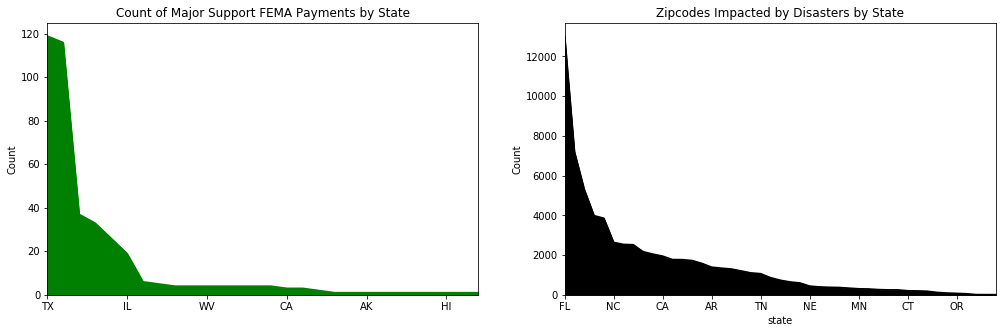

In [103]:
plt.figure(figsize=(17,5))

plt.subplot(1,2,1)
df.loc[df['tot_approve_ihp_amt'] >threshold,'state'].value_counts().plot(kind='area', color='green');
plt.title('Count of Major Support FEMA Payments by State');
plt.ylabel('Count');

plt.subplot(1,2,2)


df.groupby('state')['disaster_number'].count().sort_values(ascending=False).plot(kind='area', color='black');
plt.title('Zipcodes Impacted by Disasters by State');
plt.ylabel('Count');

Unsurpsiringly, TX, LA are two states which recieve a significant amount of major, a-typical FEMA support payments. An additional view of frequency of disaster-related payments at the zipcode level, however, shows that FL and NC are most often recieving these funds.

### NaNs

In [53]:
We'll now take a moment to look at the distribution of our target. Clearly, there are some disaster payouts skewing our distribution below...#### NO PAYOUT: When and Where, and How Often

***How Often FEMA doesn't pay out***#Find the percent of instances where there is no payout
df.loc[df['tot_approve_ihp_amt'] ==0].count()[0] / len(df['tot_approve_ihp_amt'])#Where does FEMA not payout? Check by State
plt.figure(figsize=(12,5))
((df.loc[df['tot_approve_ihp_amt'] > 0, 'state'].value_counts() / df['state'].value_counts()).sort_values(ascending=False) * 100).plot(kind='bar');
df['duration'] = df['duration'].fillna(0)
df_for_model['duration'] = df_for_model['duration'].fillna(0)

### Dummify

In [54]:
df_for_model = pd.get_dummies(df_for_model)

In [55]:
df_for_model.shape

(68731, 69)

***
## Modeling

### Remove features that are duplicative with target

In [56]:
df_for_model.columns

Index(['valid_registration', 'avg_damage', 'tot_damage', 'no_damage',
       'approve_assistance', 'tot_approve_ihp_amt', 'repair_replace_amt',
       'rental_amt', 'other_needs_amt', 'tot_max_grants', 'Median', 'Mean',
       'Pop', 'duration', 'registrations_per_capita',
       'incident_type_Earthquake', 'incident_type_Fire', 'incident_type_Flood',
       'incident_type_Hurricane', 'incident_type_Mud/Landslide',
       'incident_type_Other', 'incident_type_Severe Storm(s)',
       'incident_type_Tornado', 'incident_type_Volcano', 'state_AK',
       'state_AL', 'state_AR', 'state_AS', 'state_CA', 'state_CO', 'state_CT',
       'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA',

In [57]:
df_for_model = df_for_model.drop(columns=['avg_damage','no_damage', 'repair_replace_amt',
       'rental_amt', 'other_needs_amt', 'tot_max_grants', 'Mean', 'Pop', 'duration', 'Median', 'registrations_per_capita', 
        'approve_assistance', 'valid_registration',])

In [58]:
df_for_model.columns

Index(['tot_damage', 'tot_approve_ihp_amt', 'incident_type_Earthquake',
       'incident_type_Fire', 'incident_type_Flood', 'incident_type_Hurricane',
       'incident_type_Mud/Landslide', 'incident_type_Other',
       'incident_type_Severe Storm(s)', 'incident_type_Tornado',
       'incident_type_Volcano', 'state_AK', 'state_AL', 'state_AR', 'state_AS',
       'state_CA', 'state_CO', 'state_CT', 'state_FL', 'state_GA', 'state_HI',
       'state_IA', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NY', 'state_OH', 'state_OK', 'state_OR',
       'state_PA', 'state_PR', 'state_SC', 'state_SD', 'state_TN', 'state_TX',
       'state_VA', 'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='object')

In [59]:
df_for_model.dtypes.values

array([dtype('int64'), dtype('float64'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8')],
   

In [60]:
df_for_model.filter(like='Hurricane', axis=0);

,tot_damage,tot_approve_ihp_amt,incident_type_Earthquake,incident_type_Fire,incident_type_Flood,incident_type_Hurricane,incident_type_Mud/Landslide,incident_type_Other,incident_type_Severe Storm(s),incident_type_Tornado,...,state_PR,state_SC,state_SD,state_TN,state_TX,state_VA,state_WA,state_WI,state_WV,state_WY


### Build X, y

After removing NaNs and dummyifing our dataset we're now ready to move forward with modeling. 

In [61]:
#Build our feature set and target set for model implementation
X = df_for_model.drop(columns=['tot_approve_ihp_amt'])
y= df_for_model['tot_approve_ihp_amt']

### Train/Test Split

We'll start by splitting our data into train and test datasets for validation.

In [62]:
#Train test split our data prior to implementation for validation
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .2,
                                                    random_state = 42)

### Scale

Some of the features we are working with are on significantly different scales. Let's leverage Standard Scaler to adjust these prior to modeling.

In [63]:
#Scale both our train and test data sets
X_train_sc = StandardScaler().fit_transform(X_train)
X_test_sc = StandardScaler().fit_transform(X_test)

### Build Models

We'll inspet a number of different models to find the best candidate for us. This will include Linear Regression, KNN, Decision Tree Regressor, Bagged Regressor, RandomForest, and Adaboost.

In [64]:
#Fit each individual model with our X_train data
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train)


C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [102]:
# #Assess the performance of each model against our train and test data sets
display(linear_reg.score(X_train, y_train))
display(linear_reg.score(X_test, y_test))

In [66]:
display(knn_reg.score(X_train, y_train))
display(knn_reg.score(X_test, y_test))

0.7913579925610728

0.8028835343547327

In [67]:
display(cart_reg.score(X_train, y_train))
display(cart_reg.score(X_test, y_test))

0.9999978803192795

0.7808184316313138

In [68]:
display(bagged_reg.score(X_train, y_train))
display(bagged_reg.score(X_test, y_test))

0.9580816067979474

0.7879097067979801

In [69]:
display(random_forest_reg.score(X_train, y_train))
display(random_forest_reg.score(X_test, y_test))

0.9573579776012172

0.8109517058932907

In [70]:
display(adaboost_reg.score(X_train, y_train))
display(adaboost_reg.score(X_test, y_test))

0.8201885990715966

0.8043038406013954

From the results of our model is appear that our Adaboost implementation is demonstrating a small amount of variance and a stable R^2 score. We'll move forward with this implementation and predict against the full data set.

In [78]:
#Use our model to predict against the full training data set so we can feed into Tableau
preds = knn_reg.predict(X)

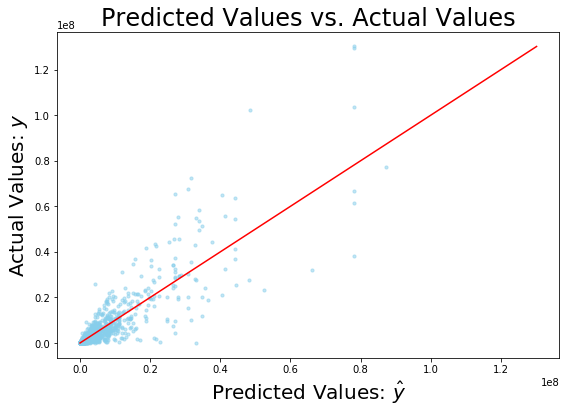

In [79]:
#Build a graphic to asses our residuals
plt.figure(figsize=(9,6))

plt.scatter(preds, y, s=10, color='skyblue', alpha = 0.5)

plt.plot([0, np.max(y)],
         [0, np.max(y)],
         color = 'red')
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [74]:
#check the s
preds.shape

(68731,)

In [80]:
#Feed our preds back into original data set
df['predictions'] = preds

In [83]:
df.to_csv('for_tableau.csv', index=False)